In [218]:
########## Import All common Library and Setting up folder
import os
import time
import sys
from datetime import datetime

# Data science common library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import csv
import sqlite3


# Common folder for all raw data
Path_Raw_Data=r'C:\Users\HP\Desktop\Data Scientist\DB_Sample_Data\\'

#update the folder name
Path=r'C:\Users\HP\Desktop\Resume\Jobs Applied\Deloitte ME - A&C\Python'
Path_Data=Path+'\\Data\\'

# Changing path to currrent folder
os.chdir(Path)

# Setting sqlite3 DB
db_sqlite3=sqlite3.connect(Path_Data+'Python.db')

print(datetime.now())

2021-11-09 01:42:19.152558


In [219]:
########## Data Loading
print(datetime.now())

df_sales = pd.read_csv(Path_Data+'sales.csv',delimiter=',',quotechar='"'
                      #,dtype={'Store':str}
                      ,encoding='ISO-8859-1',low_memory=False
                     )
# write DFto DB as table
df_sales.to_sql('df_sales',db_sqlite3,if_exists='replace')

df_products = pd.read_csv(Path_Data+'products.csv',delimiter=',',quotechar='"'
                      #,dtype={'Store':str}
                         #,parse_dates=["Date"]
                      ,encoding='ISO-8859-1',low_memory=False
                     )
# write DFto DB as table
df_products.to_sql('df_products',db_sqlite3,if_exists='replace')

df_price_changes = pd.read_csv(Path_Data+'price_changes.csv',delimiter=',',quotechar='"'
                      #,dtype={'Store':str}
                       #,parse_dates=["Date"]
                      ,encoding='ISO-8859-1',low_memory=False
                     )
# write DFto DB as table
df_price_changes.to_sql('df_price_changes',db_sqlite3,if_exists='replace')

'''
# reading from xls file
xls=pd.ExcelFile(Path_Data+'Test.xlsx')

Test=pd.read_excel(xls,'Sheet1',dtype={'custommerID':str})
# write DFto DB as table
Test.to_sql('Test',db_sqlite3,if_exists='replace')

'''
print(datetime.now())

2021-11-09 01:42:19.297554
2021-11-09 01:42:22.158354


# Sneak Peek into the Data
Lets see how the tables look and get some basic information. i.e 
* Data types
* No of Data (rows and column)
* Null Data
* few rows to understand the data

In [220]:
print(datetime.now())

print('\n df_sales \n')
print(df_sales.info())
print('\n')
print(df_sales.head())
print('\n')
print('\n df_products \n')
print(df_products.info())
print('\n')
print(df_products.head())
print('\n')
print('\n df_price_changes \n')
print(df_price_changes.info())
print('\n')
print(df_price_changes.head())
print('\n')

print(datetime.now())

2021-11-09 01:42:22.202324

 df_sales 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44167 entries, 0 to 44166
Data columns (total 13 columns):
ProductID                 44167 non-null object
Channel                   44167 non-null object
Country                   44167 non-null object
WeekKey                   44167 non-null int64
CSP                       44167 non-null float64
SalesVolume               44167 non-null int64
TotalStockVolume          44167 non-null int64
StoreStockVolume          44167 non-null int64
DepotStockVolume          44167 non-null int64
FutureCommitmentVolume    44167 non-null int64
IntakeVolume              44167 non-null int64
StoresWithStockCount      44167 non-null float64
StoresWithSalesCount      44167 non-null float64
dtypes: float64(3), int64(7), object(3)
memory usage: 4.4+ MB
None


  ProductID Channel Country  WeekKey     CSP  SalesVolume  TotalStockVolume  \
0  135fc45e  Stores       B   201502  18.984            3                39   
1  1

looking into the data I come to the conclusion that we can group sales and product data based on the ProductID .
Also we can check how Season affecting sales.

# **Analysis Datewise**

let explore data based on the timeline

* lets Merge Feature tables and sales tables based on the date 
* we will convert WeeklySales in Millions
* we will modify column as the day is holiday or not

In [221]:
df_products["Season"]=df_products["Season"].apply(lambda x: 1 if x=='R' else 0 )

In [222]:
data_sales = pd.merge(df_sales,df_products ,  how='left', on=["ProductID","ProductID"])
data_sales.drop(['ProductID','Group','SubGroup','Class','SubClass'],axis=1,inplace=True)

In [223]:
data_Week = data_sales.groupby(["WeekKey"]).agg({
											"CSP":"sum"
                                            ,"SalesVolume":"sum"
                                            ,"TotalStockVolume":"sum"
											,"StoreStockVolume":"sum"
											,"DepotStockVolume":"sum"
											,"FutureCommitmentVolume":"sum"
											,"IntakeVolume":"sum"
											,"StoresWithStockCount":"sum"
											,"StoresWithSalesCount":"sum"
											,"Season":"max"
                                            })
data_Week = data_Week.sort_index()
print(data_Week.describe())


data_Week.to_csv("data_Week.csv",index = True,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)

                CSP   SalesVolume  TotalStockVolume  StoreStockVolume  \
count     60.000000     60.000000         60.000000          60.00000   
mean    9979.044267   7423.466667       9215.833333        4419.00000   
std     4196.149938   4939.711501       7004.471171        3000.82021   
min     1291.429000    444.000000        521.000000         470.00000   
25%     7356.148500   2948.250000       2636.250000        1757.50000   
50%     9280.880500   7403.000000       8645.000000        4245.00000   
75%    11330.292000  10903.000000      12756.250000        6614.50000   
max    19971.120000  17666.000000      31870.000000       10361.00000   

       DepotStockVolume  FutureCommitmentVolume  IntakeVolume  \
count         60.000000               60.000000     60.000000   
mean        2768.566667             1580.083333    448.183333   
std         2896.016027             1404.710988    482.910614   
min           21.000000                0.000000     -2.000000   
25%          204.

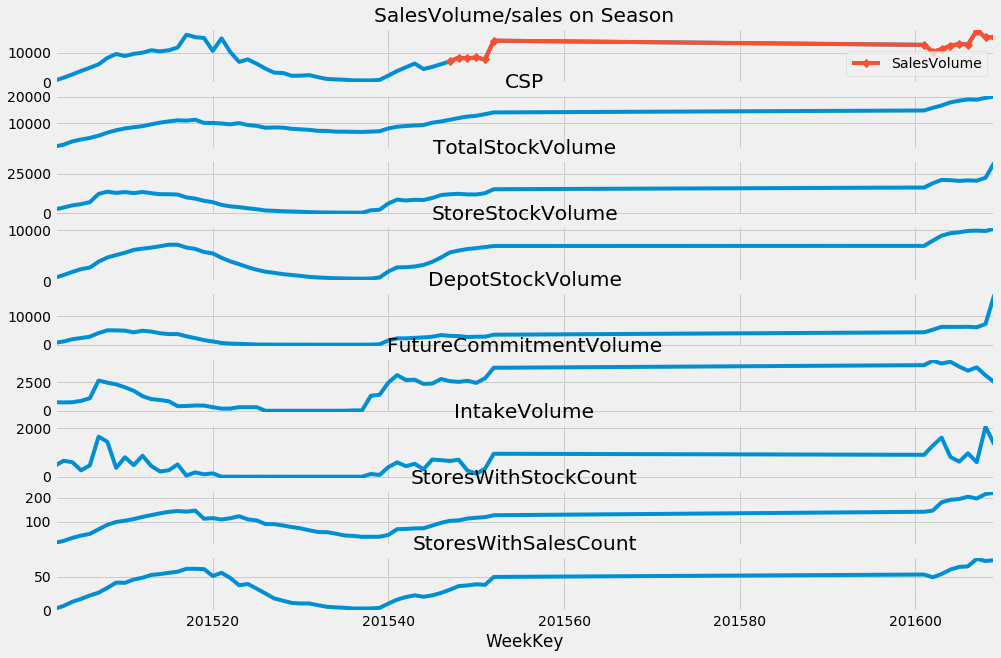

In [224]:
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(15,4))
fig, ax = plt.subplots(9,1,figsize=(15,10),sharex=True)
data_Week["SalesVolume"].plot(ax=ax[0],title="SalesVolume/sales on Season")
data_Week[data_Week.Season==1]["SalesVolume"].plot(marker="D",ax=ax[0],legend="Season sale")
data_Week["CSP"].plot(ax=ax[1], title="CSP")
data_Week["TotalStockVolume"].plot(ax=ax[2], title="TotalStockVolume")
data_Week["StoreStockVolume"].plot(ax=ax[3], title="StoreStockVolume")
data_Week["DepotStockVolume"].plot(ax=ax[4], title="DepotStockVolume")
data_Week["FutureCommitmentVolume"].plot(ax=ax[5], title="FutureCommitmentVolume")
data_Week["IntakeVolume"].plot(ax=ax[6], title="IntakeVolume")
data_Week["StoresWithStockCount"].plot(ax=ax[7], title="StoresWithStockCount")
data_Week["StoresWithSalesCount"].plot(ax=ax[8], title="StoresWithSalesCount")

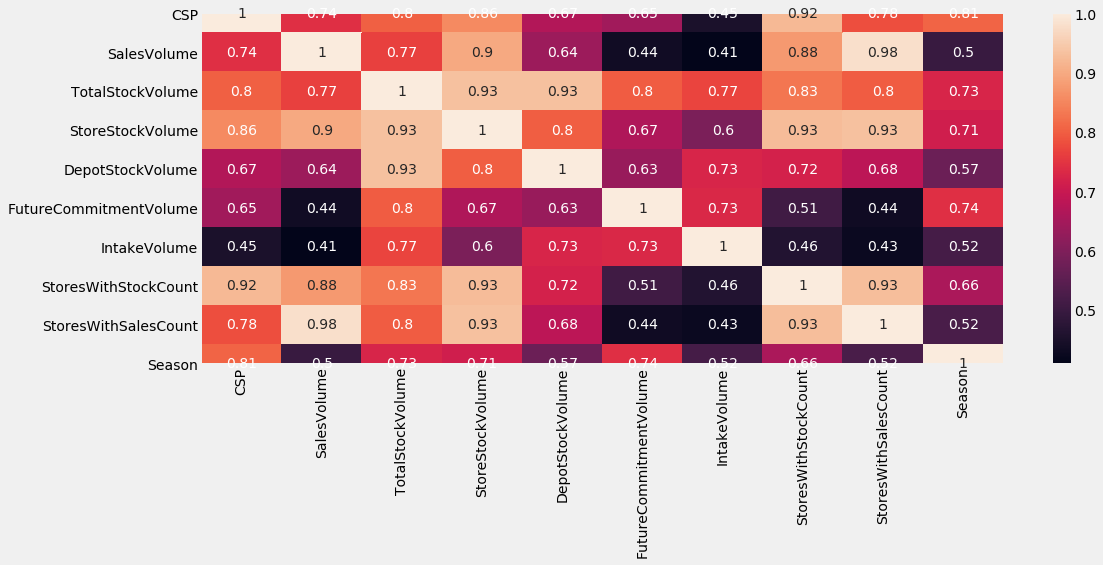

In [225]:
plt.figure(figsize=(16,6))
sns.heatmap(data_Week.corr(),annot=True)

In [226]:
data_sales

,Channel,Country,WeekKey,CSP,SalesVolume,TotalStockVolume,StoreStockVolume,DepotStockVolume,FutureCommitmentVolume,IntakeVolume,StoresWithStockCount,StoresWithSalesCount,Season
0,Stores,B,201502,18.984,3,39,6,33,0,0,0.10100,0.0078,0
1,Stores,A,201502,15.833,2,2,2,0,0,0,0.24100,0.0389,0
2,Stores,B,201502,18.084,1,6,2,3,0,1,0.06220,0.0039,0
3,Stores,B,201502,13.583,6,6,2,4,0,0,0.02328,0.0194,0
4,Stores,B,201502,14.483,8,117,7,8,102,0,0.22930,0.0350,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44162,Stores,A,201609,10.270,0,0,0,0,0,0,0.00000,0.0000,0
44163,Stores,B,201609,10.207,0,0,0,0,0,0,0.00000,0.0000,0
44164,Stores,B,201609,12.683,0,0,0,0,0,0,0.00000,0.0000,0
44165,Online,B,201609,15.383,5,2,0,2,0,0,0.00390,0.0039,0


# Analysis Channel Type, Country and Year/Week Wise

In [227]:
##################### Export ByYear
print(datetime.now())

query ='''
SELECT 
Channel
,Country
,substr(WeekKey,1,4) as year
,substr(WeekKey,5,2) as week
,max(Season) Season
,sum(SalesVolume) SalesVolume
,sum(FutureCommitmentVolume) FutureCommitmentVolume                                                                                  
FROM df_sales a

left join (
select 
ProductID
,case when Season  ='R' then 1 else 0 end Season
from df_products 
)b on a.ProductID=b.ProductID

group by 
Channel
,Country
,substr(WeekKey,1,4)
,substr(WeekKey,5,2)

'''
data_sales_Channel_country=pd.read_sql(query,db_sqlite3)
print(data_sales_Channel_country)
data_sales_Channel_country.to_csv("data_sales_Channel_country.csv",index = False,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)

print(datetime.now())

2021-11-09 01:42:27.366762
    Channel Country  year week  Season  SalesVolume  FutureCommitmentVolume
0    Online       B  2015   02       0           45                       2
1    Online       B  2015   03       0          132                       2
2    Online       B  2015   04       0          208                       2
3    Online       B  2015   05       0          279                       2
4    Online       B  2015   06       0          384                       0
..      ...     ...   ...  ...     ...          ...                     ...
175  Stores       B  2016   05       1        11509                    3875
176  Stores       B  2016   06       1        11037                    3525
177  Stores       B  2016   07       1        14784                    3813
178  Stores       B  2016   08       1        13345                    3110
179  Stores       B  2016   09       1        13196                    2510

[180 rows x 7 columns]
2021-11-09 01:42:27.727537


# **Prediction on Date and Store**

In [333]:
>>> # explicitly require this experimental feature
>>> from sklearn.experimental import enable_iterative_imputer  # noqa
>>> # now you can import normally from sklearn.impute
>>> from sklearn.impute import IterativeImputer

from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.linear_model import ElasticNet, Lasso, RidgeCV,LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

**Clean up and preprocessing**

In [334]:
def createdummies(data,cols):
    for col in cols:
        one_hot = pd.get_dummies(data[col],prefix=col)
        data = data.join(one_hot)
        data.drop(col,axis = 1,inplace=True)
    
    return data

In [349]:
data_table=data_sales_Channel_country
data_table.to_csv("data_table.csv",index = True,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)

In [336]:
data_table

,Channel,Country,year,week,Season,SalesVolume,FutureCommitmentVolume
0,Online,B,2015,02,0,45,2
1,Online,B,2015,03,0,132,2
2,Online,B,2015,04,0,208,2
3,Online,B,2015,05,0,279,2
4,Online,B,2015,06,0,384,0
...,...,...,...,...,...,...,...
175,Stores,B,2016,05,1,11509,3875
176,Stores,B,2016,06,1,11037,3525
177,Stores,B,2016,07,1,14784,3813
178,Stores,B,2016,08,1,13345,3110


In [351]:
#create dummies out of categorical column
data_table = createdummies(data_table,["Channel","Country","year","week"])
data_table.to_csv("data_table_Final.csv",index = True,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)

In [338]:
data_table.columns

Index(['Season', 'SalesVolume', 'FutureCommitmentVolume', 'Channel_Online',
       'Channel_Stores', 'Country_A', 'Country_B', 'year_2015', 'year_2016',
       'week_01', 'week_02', 'week_03', 'week_04', 'week_05', 'week_06',
       'week_07', 'week_08', 'week_09', 'week_10', 'week_11', 'week_12',
       'week_13', 'week_14', 'week_15', 'week_16', 'week_17', 'week_18',
       'week_19', 'week_20', 'week_21', 'week_22', 'week_23', 'week_24',
       'week_25', 'week_26', 'week_27', 'week_28', 'week_29', 'week_30',
       'week_31', 'week_32', 'week_33', 'week_34', 'week_35', 'week_36',
       'week_37', 'week_38', 'week_39', 'week_40', 'week_41', 'week_42',
       'week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48',
       'week_49', 'week_50', 'week_51', 'week_52'],
      dtype='object')

**Data Split**

In [339]:
data_train = data_table.query('(year_2016!="1") & (week_08!="1" | week_09!="1")')
data_train= data_table
data_test = data_table.query('(year_2016=="1") & (week_08=="1" | week_09=="1")')
X = data_train.drop('SalesVolume', axis=1)
y = data_train['SalesVolume']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [340]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 61 columns):
Season                    180 non-null int64
SalesVolume               180 non-null int64
FutureCommitmentVolume    180 non-null int64
Channel_Online            180 non-null uint8
Channel_Stores            180 non-null uint8
Country_A                 180 non-null uint8
Country_B                 180 non-null uint8
year_2015                 180 non-null uint8
year_2016                 180 non-null uint8
week_01                   180 non-null uint8
week_02                   180 non-null uint8
week_03                   180 non-null uint8
week_04                   180 non-null uint8
week_05                   180 non-null uint8
week_06                   180 non-null uint8
week_07                   180 non-null uint8
week_08                   180 non-null uint8
week_09                   180 non-null uint8
week_10                   180 non-null uint8
week_11                   180 non-null u

**Basic Model Creation**

In [341]:
classifiers = [
    LinearRegression(),
    ElasticNet(),
    RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=3, coef0=2.5),
    Lasso(alpha =16, random_state=100),
    ElasticNet(alpha=0.8),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    SVR(), 
    LinearSVR(), 
    NuSVR(),
    xgb.XGBRegressor(),
    lgb.LGBMRegressor()
    ]

name = []
score = []
models = []
rmse = []
i = 0
for classifier in classifiers:
    classifier.fit(X_train, y_train)   
    name.append(type(classifier).__name__)
    score.append(classifier.score(X_test, y_test))
    models.append(classifier)
    rmse.append(np.sqrt(mean_squared_error(classifier.predict(X_test), y_test)))


**Comparing Model Performance**

In [348]:
df_score = pd.DataFrame(list(zip(name,rmse, score, models)),columns=['name','rmse','score',"model"])
df_score.set_index('name',inplace=True)
df_score.sort_values(by=['score'],inplace=True)
df_score.to_csv("score.csv",index = True,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)
df_score

,rmse,score,model
name,,,
KernelRidge,31586.158947,-79.351766,"KernelRidge(alpha=0.6, coef0=2.5, degree=3, ga..."
SVR,3803.448528,-0.165083,"SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..."
NuSVR,3561.267016,-0.021435,"NuSVR(C=1.0, cache_size=200, coef0=0.0, degree..."
LinearRegression,3018.242312,0.266314,"LinearRegression(copy_X=True, fit_intercept=Tr..."
LinearSVR,2690.252394,0.417108,"LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_i..."
Lasso,2567.442230,0.469112,"Lasso(alpha=16, copy_X=True, fit_intercept=Tru..."
ElasticNet,2277.462823,0.582262,"ElasticNet(alpha=1.0, copy_X=True, fit_interce..."
ElasticNet,2251.474295,0.591741,"ElasticNet(alpha=0.8, copy_X=True, fit_interce..."
RidgeCV,2152.322624,0.626907,"RidgeCV(alphas=array([0.001, 0.01 , 0.1 , 1. ..."


**Prediction**

In [344]:
data_test.drop(['SalesVolume'],axis=1,inplace=True)

In [346]:
model = df_score.loc["LGBMRegressor","model"]
predict = model.predict(data_test)
predict

array([ 1155.29989784,  1155.29989784,  1198.29151967,  1198.29151967,
       10281.90941904, 10281.90941904])

In [352]:
model.feature_importances_

array([ 50, 155,  52,   0,  50,   0,  10,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

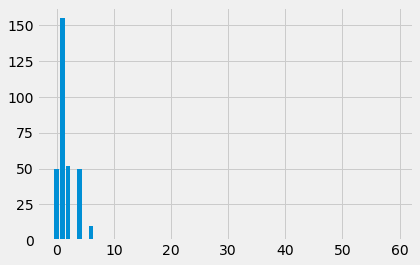

In [350]:
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

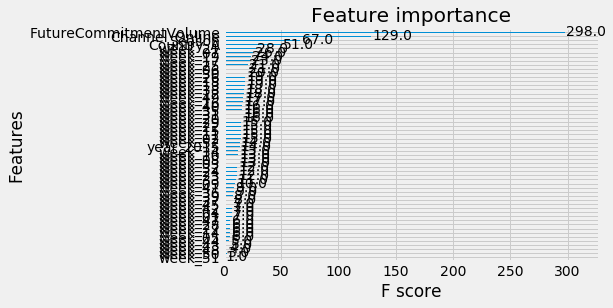

<Figure size 2160x2160 with 0 Axes>

In [326]:
from xgboost import plot_importance
plot_importance(model)
plt.figure(figsize=(30,30))
plt.show()

In [327]:
plot_importance

<function xgboost.plotting.plot_importance(booster, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', xlabel='F score', ylabel='Features', fmap='', importance_type='weight', max_num_features=None, grid=True, show_values=True, **kwargs)>

In [241]:
data_test

,Season,FutureCommitmentVolume,Channel_Online,Channel_Stores,Country_A,Country_B,year_2015,year_2016,week_01,week_02,...,week_43,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52
56,1,2,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
57,1,2,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,3,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
59,1,1,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
116,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
117,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
118,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
119,1,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
176,1,3525,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
177,1,3813,0,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [295]:
##################### Pricing table
print(datetime.now())

db_sqlite3.execute("DROP TABLE IF EXISTS Pricing_trs")

query='''

CREATE TABLE Pricing_trs AS

select 
a.ProductID
,a.WeekKey
,a.Channel
,a.Country
,a.OSP
,a.previous_CSP
,a.CSP
,c."Group"
,c.SubGroup
,c."Class"
,c.SubClass
,c.Season
-- ,d.WeekKey_Price_End
-- ,b.WeekKey as Sales_Week 
,sum(b.SalesVolume) SalesVolume
from df_price_changes a

left join 
(
select 
ProductID
,WeekKey_Price_Start
,case when WeekKey_Price_End is null then '202101' else WeekKey_Price_End end WeekKey_Price_End
from
(
select 
ProductID
,WeekKey WeekKey_Price_Start
,LEAD (WeekKey) OVER (partition by ProductID ORDER BY WeekKey) AS WeekKey_Price_End
from df_price_changes a
group by 
ProductID
,WeekKey
)a
) d on a.ProductID=d.ProductID and a.WeekKey =d.WeekKey_Price_Start

left join (
select 
ProductID,WeekKey,Channel,Country
,sum(SalesVolume) SalesVolume
from df_sales
group by ProductID,WeekKey,Channel,Country
) b
on a.ProductID=b.ProductID 
and b.WeekKey between a.WeekKey and d.WeekKey_Price_End
and a.Channel=b.Channel 
and a.Country=b.Country 

left join (

select 
ProductID
,"Group"
,SubGroup
,"Class"
,SubClass
,case when Season  ='R' then 1 else 0 end Season
from df_products 

)c on a.ProductID=c.ProductID

-- where a.ProductID='10516724'

group by 

a.ProductID
,a.WeekKey
,a.Channel
,a.Country
,a.OSP
,a.previous_CSP
,a.CSP
,c."Group"
,c.SubGroup
,c."Class"
,c.SubClass
,c.Season

'''
db_sqlite3.execute(query)
print(datetime.now())

2021-11-09 08:52:56.518722
2021-11-09 08:52:58.661320


In [300]:
##################### Export ByYear
print(datetime.now())

query ='''

select 
a.*
,case when SalesVolume  >=1 then 'Won' else 'Not Won' end Won_Not_Won 
,case 
when SalesVolume  between 1 and 10 then 'Up to 10 coversion'
when SalesVolume  between 11 and 25 then '11 to 25 coversion'
when SalesVolume  between 26 and 50 then '26 to 50 coversion'
when SalesVolume  > 50 then '50+ coversion'
end as coversion
from Pricing_trs a

'''
price_changes=pd.read_sql(query,db_sqlite3)
print(price_changes)
price_changes.to_csv("price_changes_SQL.csv",index = False,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)

print(datetime.now())

2021-11-09 09:25:22.340168
      ProductID  WeekKey Channel Country     OSP  previous_CSP     CSP  \
0      1.19E+81   201522  Online       B  12.683        12.683  11.782   
1      1.82E+08   201526  Stores       A  11.670        11.670  10.824   
2      1.82E+08   201526  Stores       B  11.332        11.332  10.657   
3      1.82E+08   201546  Stores       A  11.670        10.824  10.261   
4      1.82E+08   201546  Stores       B  11.332        10.657  10.207   
...         ...      ...     ...     ...     ...           ...     ...   
25804  ffdebf6c   201523  Stores       B  15.383        11.332  12.683   
25805  ffdebf6c   201524  Stores       B  15.383        12.683  11.332   
25806  ffe6e191   201524  Online       B  16.283        16.283  13.133   
25807  fff06c1d   201521  Online       B  14.483        14.483  12.232   
25808  fff06c1d   201522  Online       B  14.483        12.232  11.782   

          Group  SubGroup     Class  SubClass  Season  SalesVolume  \
0      606565a

In [282]:
##################### Export ByYear
print(datetime.now())

query ='''

select 
ProductID,WeekKey,Channel,Country
,sum(SalesVolume) SalesVolume
from df_sales
group by ProductID,WeekKey,Channel,Country

'''
price_changes=pd.read_sql(query,db_sqlite3)
print(price_changes)
price_changes.to_csv("price_changes_SQL1.csv",index = False,quotechar='"'
                 ,quoting=csv.QUOTE_ALL)

print(datetime.now())

2021-11-09 03:19:24.268057
      ProductID  WeekKey Channel Country  SalesVolume
0      10516724   201515  Stores       A            2
1      10516724   201515  Stores       B           17
2      10516724   201516  Online       B            1
3      10516724   201516  Stores       A            4
4      10516724   201516  Stores       B           29
...         ...      ...     ...     ...          ...
44162  fffd6ecd   201605  Stores       B           29
44163  fffd6ecd   201606  Stores       B           28
44164  fffd6ecd   201607  Stores       B           20
44165  fffd6ecd   201608  Stores       B           16
44166  fffd6ecd   201609  Stores       B           15

[44167 rows x 5 columns]
2021-11-09 03:19:24.764748
